# Optical Character Recogition (OCR) for text extraction

<span style="color:red">In this notebook, we will run through a series of techniques that will improve the OCR performance of the open source Tesseract. Tesseract was initially developed by HP labs in Bristol and then taken on by Google. 

<span style="color:red">For further details of the algorithm and the latest developments, an overview of the Tesseract engine is given here:</span> https://github.com/tesseract-ocr/docs/blob/master/tesseracticdar2007.pdf

<span style="color:red">We'll be using the standard Tesseract module which includes a pretrained model, so there's no need to train on new characters. Generally, this seem  to work well with standard fonts in PDFs. There are later versions of tesseract that use more sophisticated techniques, including using recurrent Neural Networks (specifically LSTMs) as their engine:</span>

https://github.com/tesseract-ocr/tesseract/wiki/Documentation

## 1. Import Modules

<span style="color:red">Some important modules to use with Python for OCR include:</span>

- pytessact (or tesseract-ocr). 
- PyPDF2, excellent for working with PDFs.
- OpenCV (cv2) is one of the standards for image processing. ImageMagick is also good. 
- enchant is a useful module for spellchecking. This can improve the OCR output where individual characters have been misrecognised.
- Regular expression (regex) is good for extracting useful information once the OCR is complete.

These modules have been written by people and they will do most of the work for us. For instance, pytesseract is an implementation of Tesseract for Python. If we have an picture of some text called <span style="color:orange">image</span>, we can use pytesseract as follows: 

   <span style="color:blue">Text</span> = pytesseract.image_to_string(<span style="color:orange">image</span>)

The variable <span style="color:blue">Text</span> now contains the text Tesseract recognised with its OCR algorithm in one line of code!

In [84]:
import PyPDF2
import numpy as np
import io
from wand.image import Image
from PIL import Image as Im
from enchant.checker import SpellChecker
import os
import pytesseract
import cv2
import codecs
import regex as re 
from IPython.display import Image as Img

## 2. Load PDF

<span style="color:red">First we will load our PDF using a module called PyPDF2. We can use this module to load PDFs, find the number of pages, retrieve specific pages etc.</span>

In [100]:
 pdf = PyPDF2.PdfFileReader('/home/mike/00027767.pdf') # Loads the PDF

In [101]:
print pdf.getNumPages()

33


## 3. Convert PDF to image

<span style="color:red">In the application we are looking at with Companies House, we are only interested in a small amount of data, nearly always found on a single page. Here we will convert a single page to an image format in preparation for OCR.</span>

<span style="color:red">Note that Tesseract seems to work best with with a resolution of 300 dots per inch (DPI). In some cases it may be worth zooming your image in to focus on the text if it is small, or segment lines/paragraphs of text before applying OCR.</span>

In [102]:
pagenum = 3 # page we are interested in

dst_pdf = PyPDF2.PdfFileWriter()
dst_pdf.addPage(pdf.getPage(pagenum))

pdf_bytes = io.BytesIO()
dst_pdf.write(pdf_bytes)
pdf_bytes.seek(0)

img = Image(file = pdf_bytes, resolution = 300) # Here we use the Image module to convert to a .png image
img.format = 'png'
img.save(filename='/home/mike/image.png')
img.destroy()



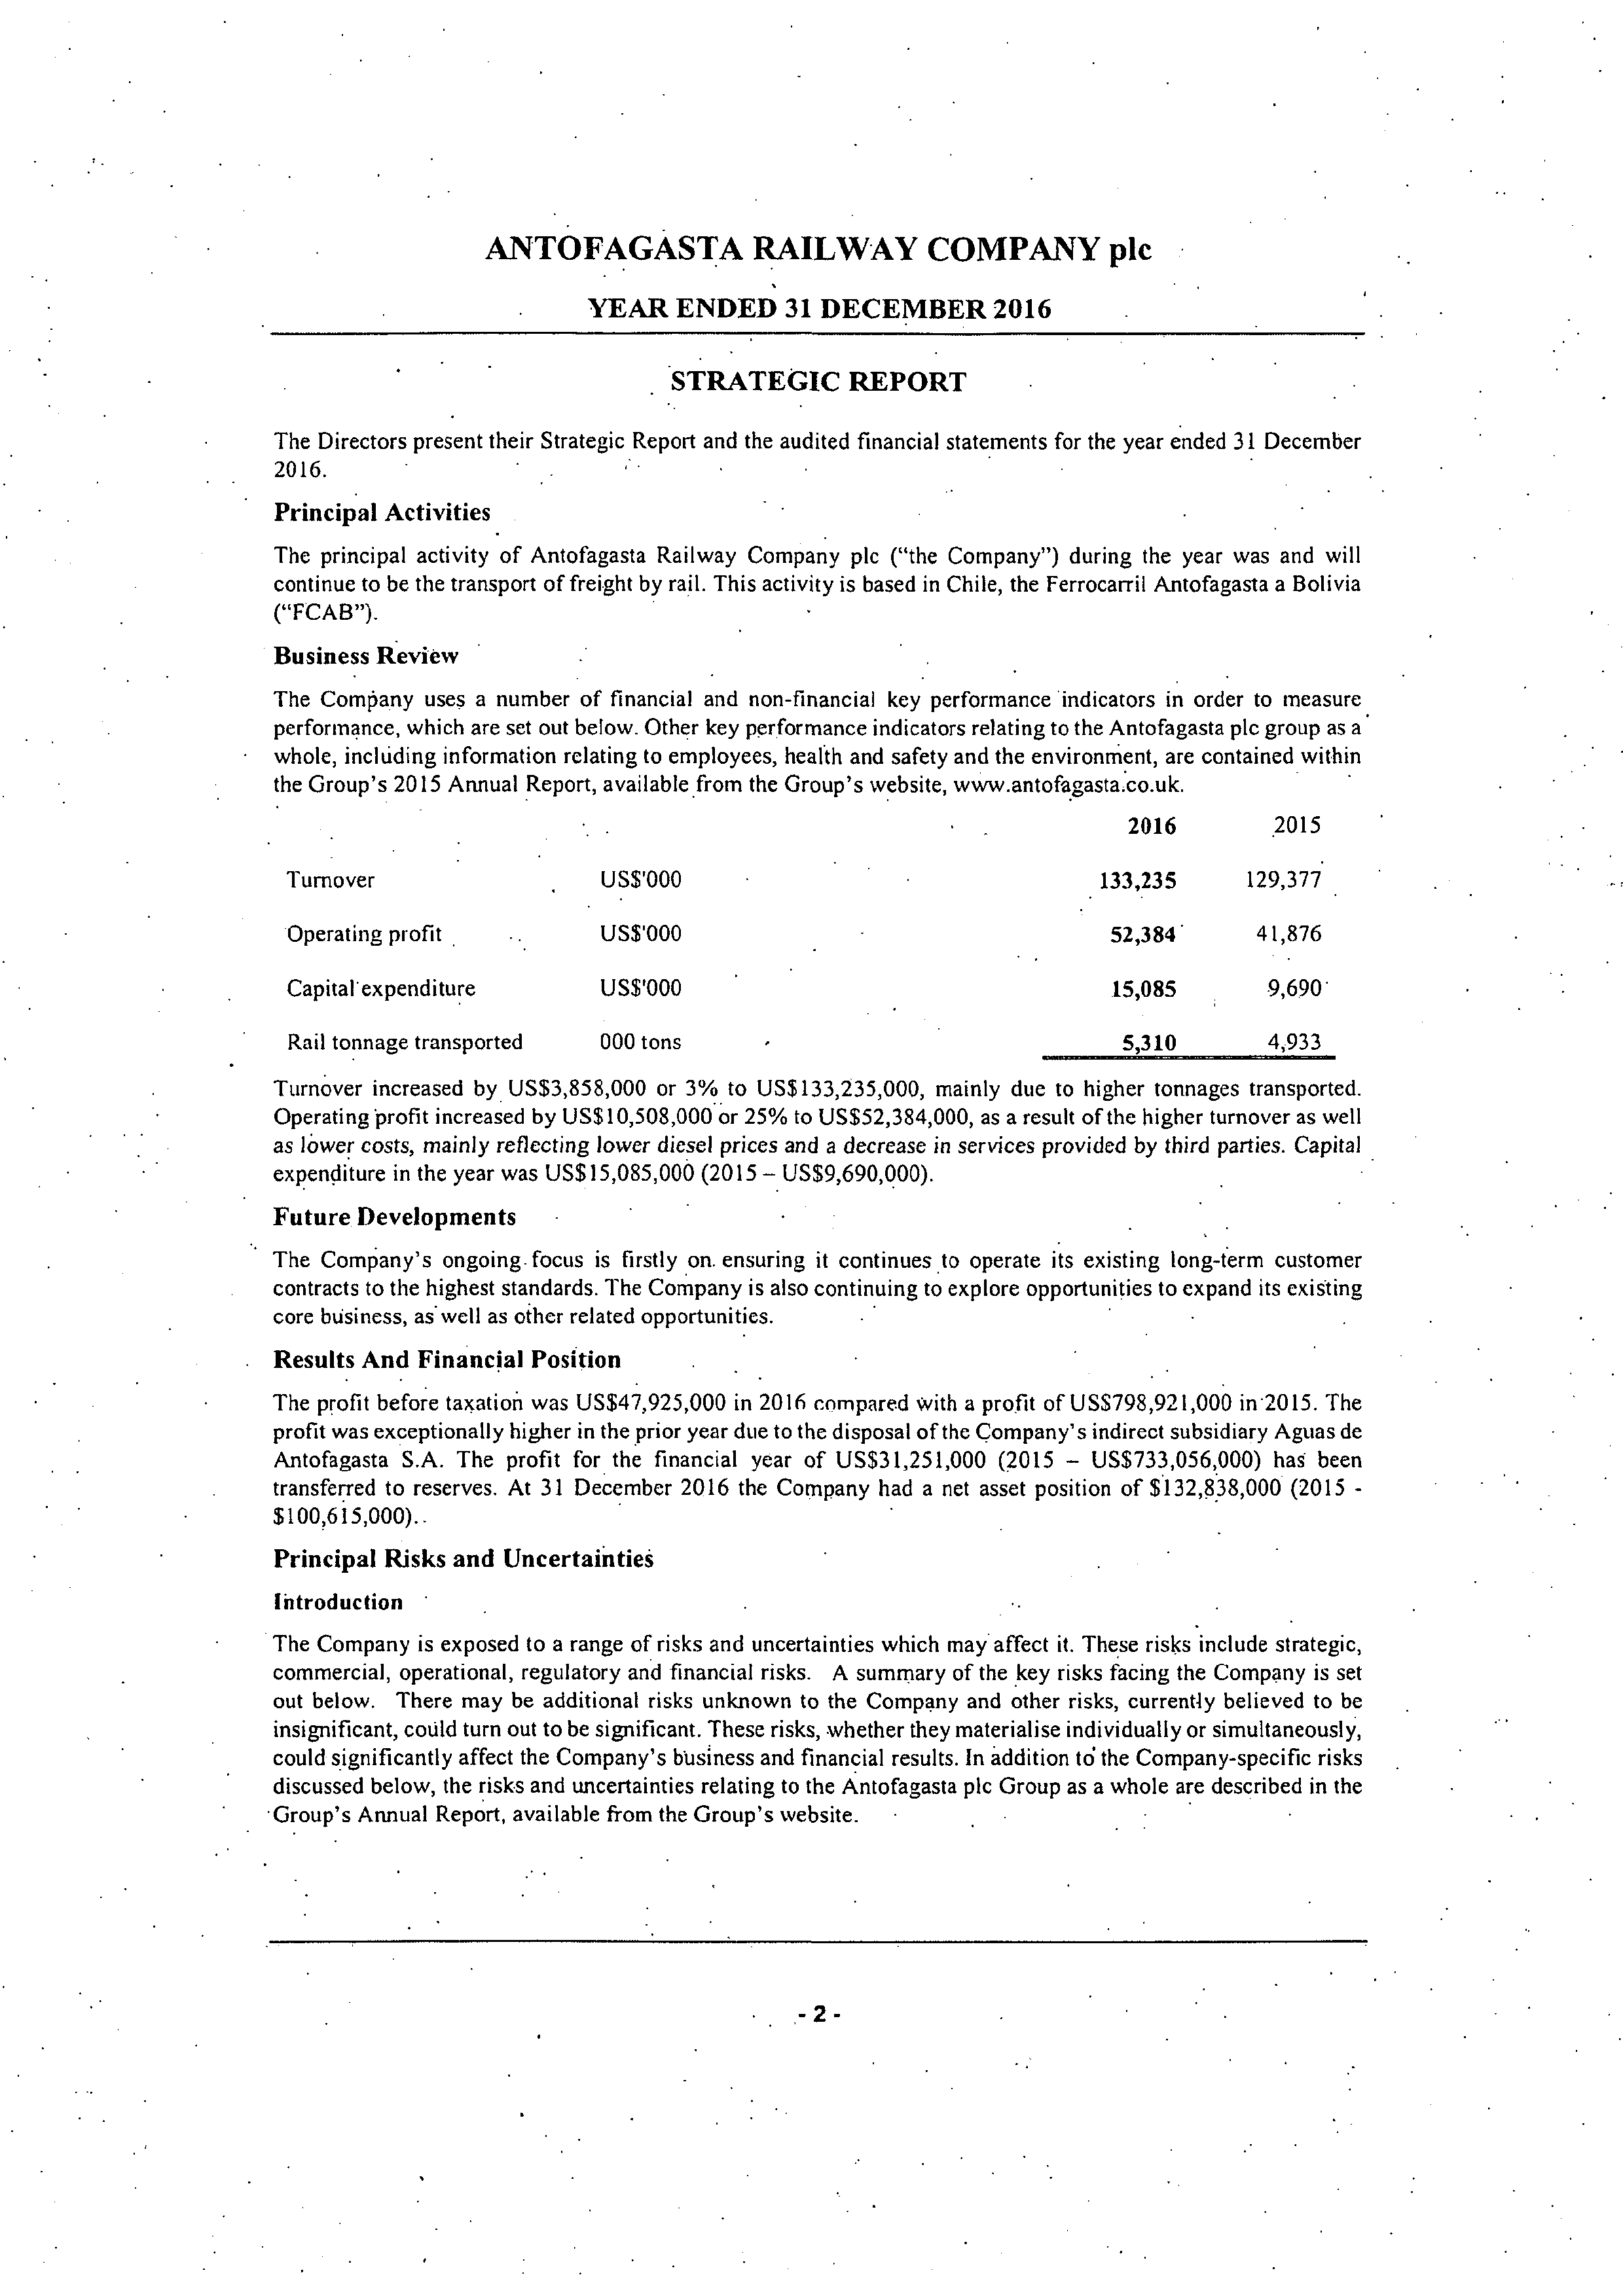

In [103]:
Img(filename='/home/mike/image.png') # This displays the image inline

## 4. Preprocessing steps to improve OCR performance

<span style="color:red">This is a typical example of a PDF on Companies House. The text is generally clear, but the image quality is not excellent.</span>

<span style="color:red">To maximise the performance of the OCR, typical steps may include:</span>
 

- Binarise the image such that the text is black and the background is white. This is to segment the text as much as possible.
- Remove unwanted noise from the image. For example the specks of black in the above image are just noise. We can remove this by thresholding or for example, after thresholding, we can set small areas of black to the colour white. 
- Horizontal alignment of text. If the image is skewed or rotated beyond a certain degree, this can result in poor OCR performance. Generally we will want to rotate the image to align the text. 
- Sharpen the text using morphological operations: https://en.wikipedia.org/wiki/Mathematical_morphology Techniques such as opening followed by closing can get rid of offshoots and poor quality text, sharpening the text quality. 

<span style="color:red">Here we will use OpenCV to demonstrate the effects of doing this.</span>


In [128]:
pdf_image = cv2.imread('/home/mike/image.png', 0) # load image as a greyscale image (pixels range [0,255])

In [139]:
#  Our image is very simple. We will threshold the image to make it binary. Everything will either be black or white.

num, grey = cv2.threshold(pdf_image, 127, 255, cv2.THRESH_BINARY)

img = 255-grey # inverting the image for morphological operations

# It is best to read the documentation on Morphological operations to understand what is going on. 
# The link is here: https://docs.opencv.org/trunk/d9/d61/tutorial_py_morphological_ops.html

kernel = np.ones((2,2), np.uint8) 

img = cv2.dilate(grey, kernel, iterations=1)

# img = cv2.medianBlur(grey, 5) # for removing noise

img = cv2.erode(img, kernel, iterations=1)

## 4.1 Some extra tools for interest

<span style="color:red">Another preprocessing idea could be to use the Fourier Transform. With the Fourier Transform you are transforming an image into the frequency domain. We are mainly interested in low frequencies where the colour is homogeneous, like the body of a character. We are not so  interested in high frequency information which will include the edges of characters and things like salt and pepper noise. In this case we can throw away the high frequency information by zeroing out everything that is not close to the centre of the centred Fourier Transform.</span>
    
<span style="color:red">Although this is pretty (read: totally!) unneccesary with this example, it does actually produce slightly better results. The code gives a crude example of how this could be done. It's a nice technique for returning only the edges of an image.</span>

In [140]:
#f = np.fft.fft2(grey)
#fshift = np.fft.fftshift(f)
#magnitude_spectrum = 20*np.log(np.abs(fshift))

#height, width = pdf_image.shape[:2]

#radius = 500

# High frequency information

#for i in range(height/2-radius, height/2 + radius):
#    for j in range((width-1)/2-radius, (width-1)/2+radius): 
#        fshift[i][j] = 0

# Low frequency information

#for i in range(0,height):
#    for j in range(0,width):
#        if i < height/2 - radius or i > height/2 + radius:
#            fshift[i][j] = 0
#        if j < (width-1)/2 - radius or j > (width-1)/2 + radius:
#            fshift[i][j] = 0

#f_ishift = np.fft.ifftshift(fshift)
#img_back = np.fft.ifft2(f_ishift)
#img = np.abs(img_back)

#img_range = img.max() - img.min()
#img = 255*(img - img.min())/img_range

#img = 255-img

#img[img < 100] = 0

<span style="color:red">Sometimes it may be that a local thresholding is required if the contrast of the image is not good. A global threshold may turn large sections of an image black, obscuring text. In this case, local thresholding using Otsu's method, or for example Adaptive Gaussian Thresholding. 

## 5. Write the image to file in preparation for OCR

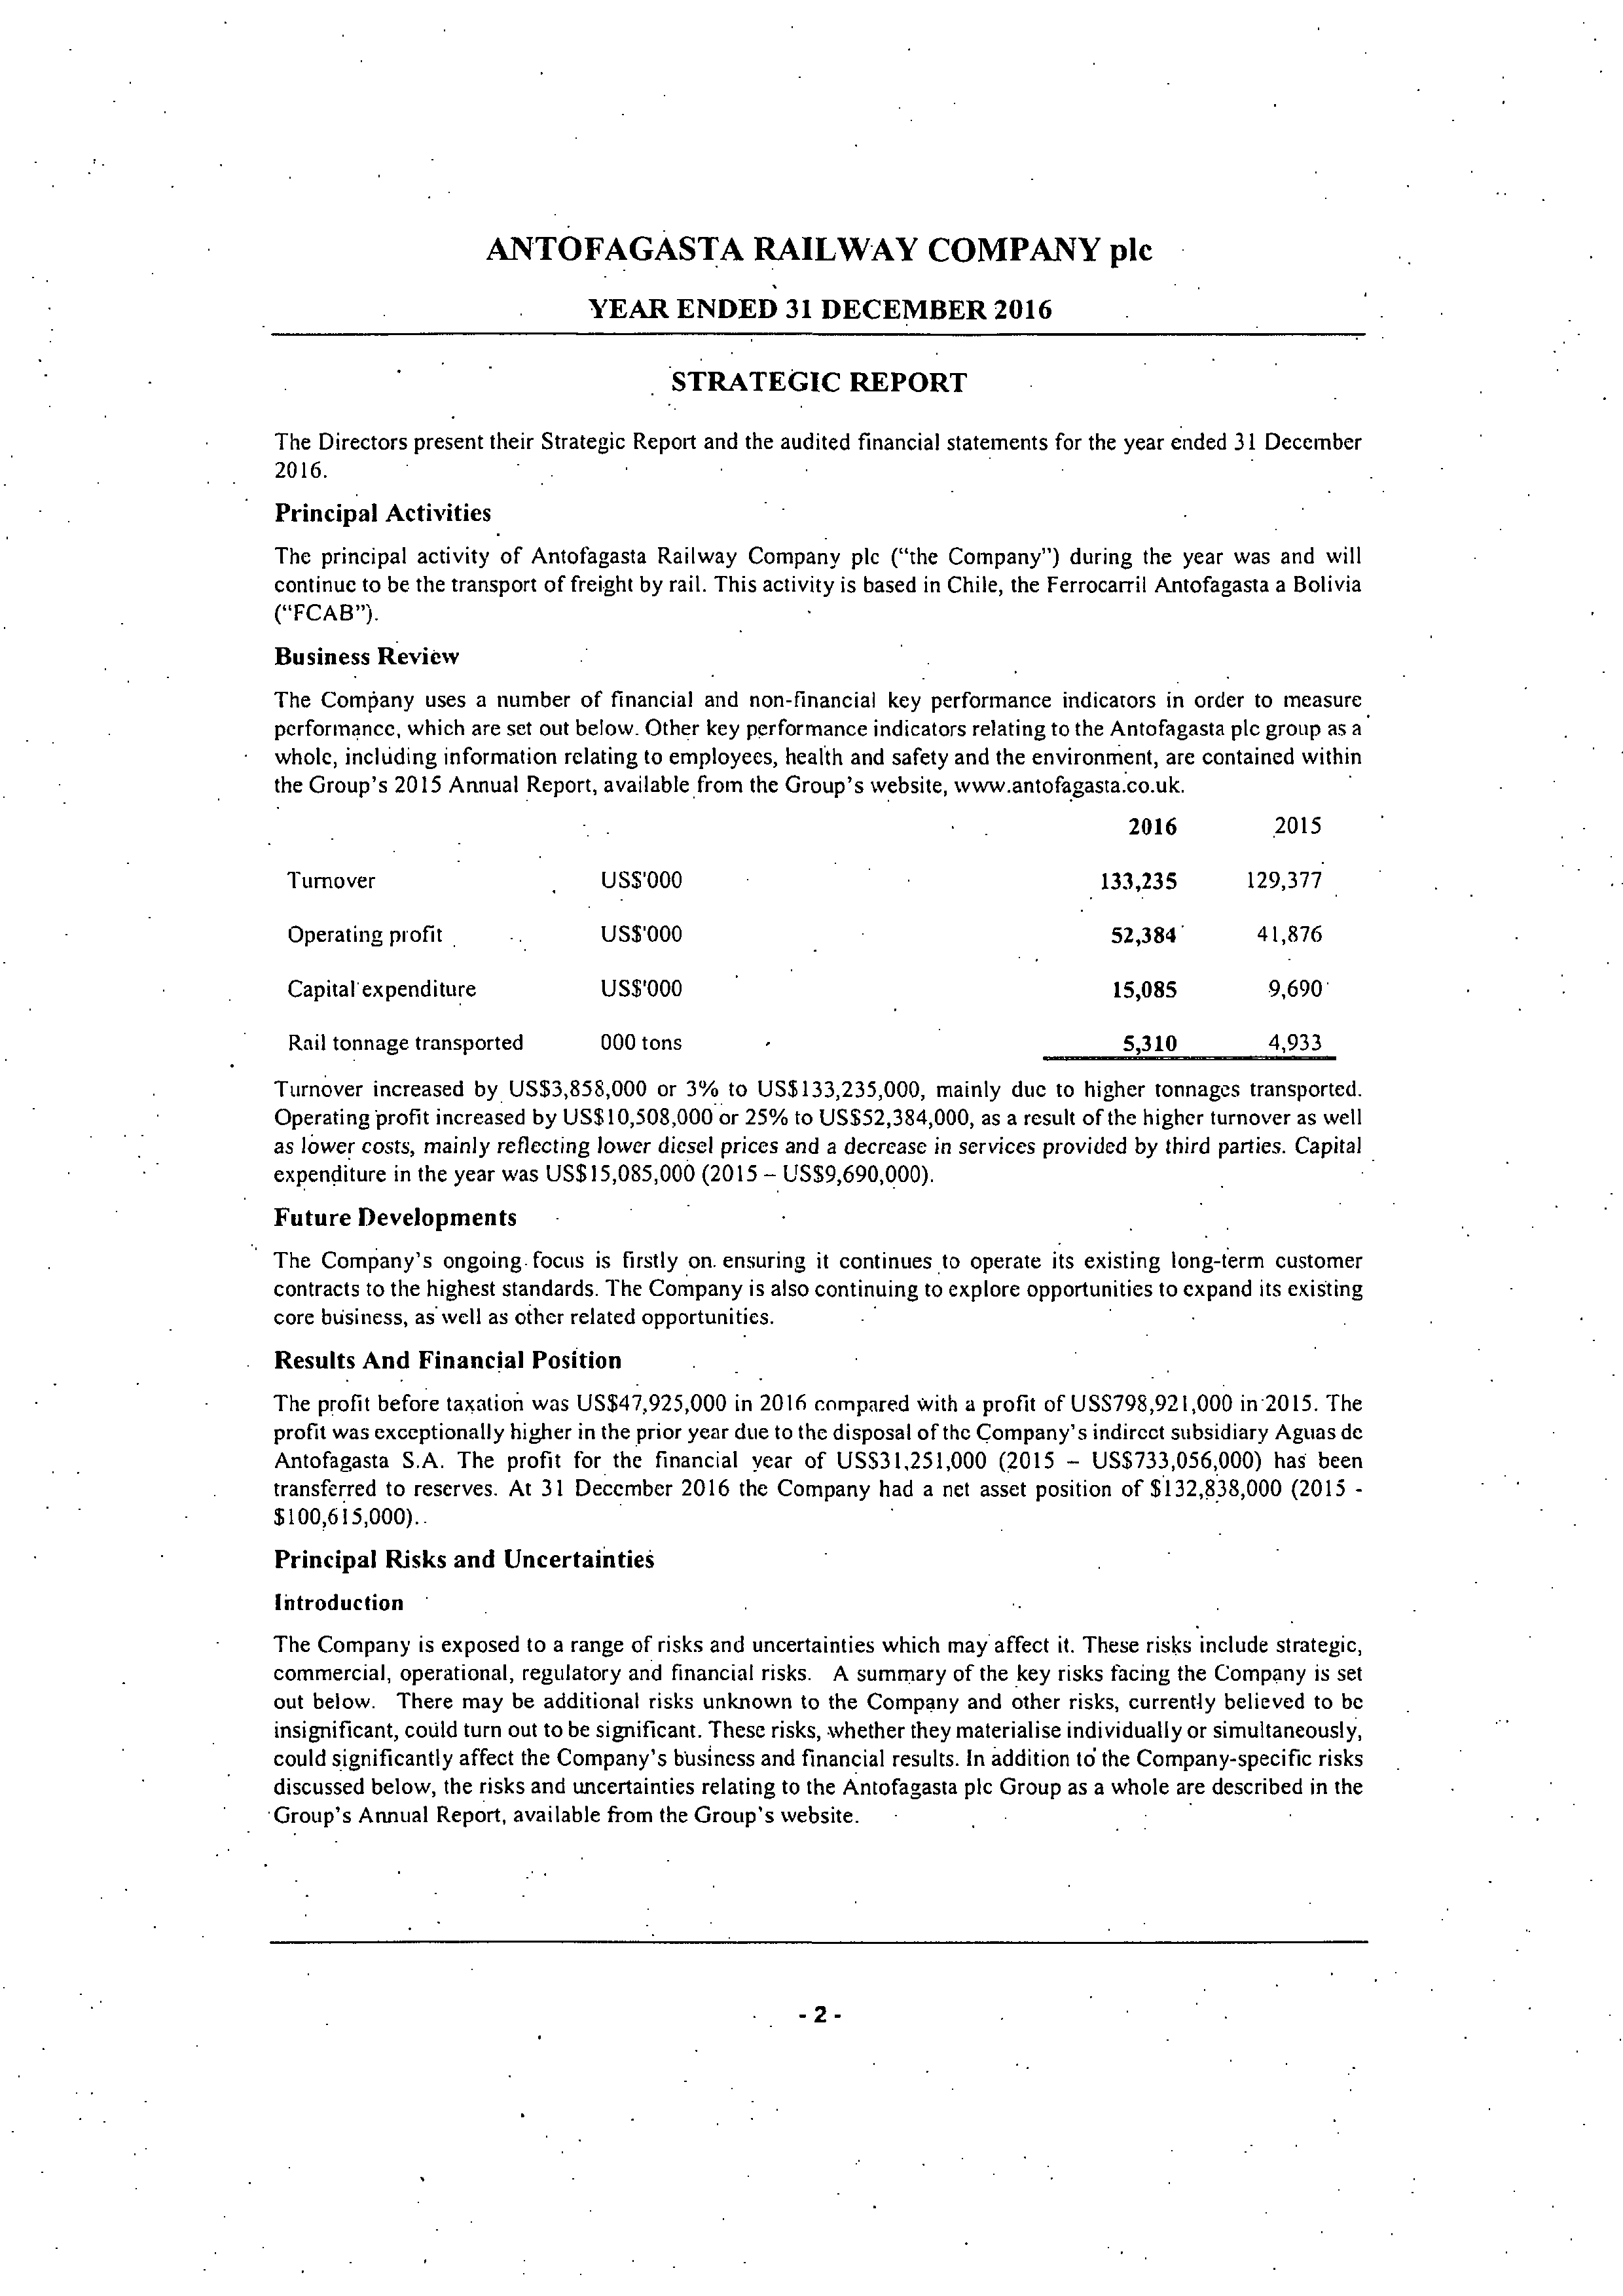

In [141]:
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, img)

Img(filename=filename) # Image after pre-processing

## 6. Run the Tesseract OCR algorithm

In [142]:
text = pytesseract.image_to_string(Im.open(filename)) # this runs Tesseract OCR on an image

In [143]:
print text

ANTOFIAIGASTA RAILWAY COMPANY plc
YEAR ENDED 31 DECEMBER 2016

 

_ STRATEGIC REPORT

The Directors present their Strategic Report and the audited ﬁnancial statements for the year ended 31 December
2016. - -

Principal Activities

The principal activity of Antofagasta Railway Company plc (“the Company") during the year was and will
continue to be the transport of freight by rail. This activity is based in Chile, the Ferrocarril Antofagasta a Bolivia
(“FCAB”). -

Business Review

The Company uses a number of ﬁnancial and non-ﬁnancial key performance indicators in order to measure
performance, which are set out below. Other key performance indicators relating to the Antofagasta plc group as a.
whole, including information relating to employees, health and safety and the environment, are contained within
the Group' 5 2015 Annual Report, available Ifrom the Group’s website, www. antofagasta. co. uk.

2016 .2015
Tumover I ' I , ussooo - ' ' - I 133,235 129,377' I
Operating proﬁt I I US$‘000

## 7. Perform a spell check on the OCR results

<span style="color:red">The output is mostly okay, with a few mistakes. If we now run a spellcheck on the output, we should have something that is acceptible. Here we will use a Python module called enchant that can both spellcheck and replace errors.</span>

In [144]:
checker = SpellChecker("en_GB") # Sets the spellcheck language 

checker.set_text(text) # This checks for errors in the 'text' variable which was the output from the OCR

for err in checker:
    if err.suggest(): 
        sug = err.suggest()[0] # replaces the error with the first spellcheck suggestion (~99% accurate)
        err.replace(sug)
    else:
        pass # error check, sometimes the strings are nonsense so there are no spellcheck suggestions
    
checked_text = checker.get_text() # retrieves the spellchecked text

In [145]:
print checked_text

ANTOFAGASTA RAILWAY COMPANY LC
YEAR ENDED 31 DECEMBER 2016

 

_ STRATEGIC REPORT

The Directors present their Strategic Report and the audited ﬁnancial statements for the year ended 31 December
2016. - -

Principal Activities

The principal activity of Antofagasta Railway Company LC (“the Company") during the year was and will
continue to be the transport of freight by rail. This activity is based in Chile, the Ferrari Antofagasta a Bolivia
(“CAB”). -

Business Review

The Company uses a number of ﬁnancial and non-ﬁnancial key performance indicators in order to measure
performance, which are set out below. Other key performance indicators relating to the Antofagasta LC group as a.
whole, including information relating to employees, health and safety and the environment, are contained within
the Group' 5 2015 Annual Report, available From the Group’s website, WWW. Antofagasta. co. UK.

2016 .2015
Tu mover I ' I , USO - ' ' - I 133,235 129,377' I
Operating proﬁt I I US$‘000 . - I 52,384

 <span style="color:red">Many mistakes has been corrected. Now we can use regular expression to extract the useful information we would like. In this application, we are interested in finding how the company describes their own activity - and typically this is done within a phase containing the key words "Principal activity" or "Principal activities".</span>

In [146]:
paragraph = re.findall(r"principal activit[^\.]+\.",checked_text, re.IGNORECASE) # regex to retrieve a sentence

<span style="color:red"> So we simply use regex to extract the text that starts with the phrase "principal activi" and ends at the next available full stop. Most of the time this sentence will  include the description of the company. </span>

In [147]:
output = codecs.open('/home/mike/description.txt', "w", encoding = 'utf-8') # write output to file
output.write(paragraph[0]) # returns the first sentence found as sometimes there will be repeats of key words
output.close()

<span style="color:red">Finally we get the desired output. Often we don't need lots of preprocessing though, so in just a few lines of code we can automate data retrieval rather than manually transcribing from images or PDFs.</span>

In [148]:
description = open('/home/mike/description.txt', 'r')

print description.read()

Principal Activities

The principal activity of Antofagasta Railway Company LC (“the Company") during the year was and will
continue to be the transport of freight by rail.
